In [1]:
import collections

import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
import random

In [3]:
env = gym.make('FrozenLake-v1', is_slippery=True)

In [11]:
state_size = env.observation_space.n
action_size = env.action_space.n
Q_table = np.zeros((state_size, action_size))

# Parameters
episodes = 2000
alpha = 0.1
gamma = 0.99
epsilon = 1.0
epsilon_decay = 0.995
min_epsilon = 0.01

reward_per_episode = []

# Updating Q-values using this bellman equation
$$
\underbrace{\text{New}Q(s,a)}_{\text{New Q-Value}} = Q(s,a) + \mkern-34mu
\underset{\text{Learning rate}}{\underbrace{\alpha}} \mkern-30mu
[\underbrace{R(s,a)}_{\text{Reward}} + \mkern-30mu
\underset{\text{Discount rate}}{\underbrace{\gamma}} \mkern-75mu
\overbrace{\max Q'(s',a')}^{\text{Maximum predicted reward, given} \\
\text{new state and all possible actions}} \mkern-45mu - Q(s,a)]
$$

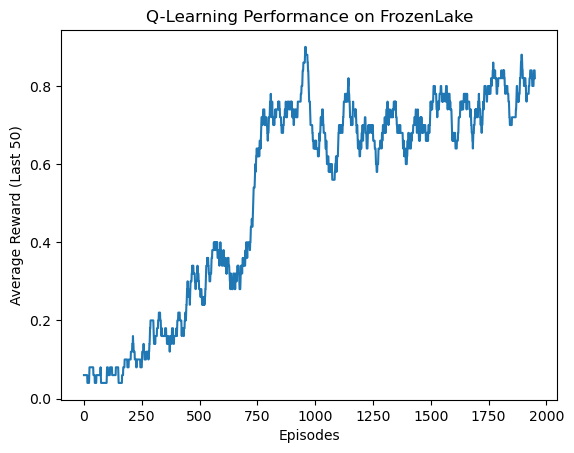

In [12]:
for episode in range(episodes):
    state, _ = env.reset()
    total_reward = 0.0
    done = False
    while not done:
        if random.uniform(0, 1) < epsilon:
            action = env.action_space.sample() # Exploration
        else:
            action = np.argmax(Q_table[state, :])

        next_state, reward, done, _, _ = env.step(action)
        Q_table[state, action] = Q_table[state, action] + alpha * (reward + gamma * np.max(Q_table[next_state, :]) - Q_table[state, action])
        state = next_state
        total_reward += reward
    # Epsilon decay
    epsilon = max(min_epsilon, epsilon_decay * epsilon)
    reward_per_episode.append(total_reward)

plt.plot(np.convolve(reward_per_episode, np.ones(50)/50, mode='valid'))
plt.xlabel("Episodes")
plt.ylabel("Average Reward (Last 50)")
plt.title("Q-Learning Performance on FrozenLake")
plt.show()

# Implementing `FrozenLake` using DQN

In [84]:
import gymnasium as gym
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np
import collections

In [85]:
# Create FrozenLake Environment
env = gym.make('FrozenLake-v1', is_slippery=True)

In [86]:
# Neural Network for Q-Function
class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super().__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)


In [87]:
state_size = env.observation_space.n
action_size = env.action_space.n
learning_rate = 0.001
gamma = 0.99
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 0.995
batch_size = 32
memory_size = 10000
num_episodes = 2000
target_update = 10

In [88]:
device = 'cpu'
print(device)
policy_net = DQN(state_size, action_size).to(device)
target_net = DQN(state_size, action_size).to(device)
target_net.load_state_dict(policy_net.state_dict())

cpu


<All keys matched successfully>

In [89]:
optimizer = torch.optim.Adam(policy_net.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss()

In [90]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        return (
            torch.tensor(states, dtype=torch.float32),
            torch.tensor(actions, dtype=torch.long),
            torch.tensor(rewards, dtype=torch.float32),
            torch.tensor(next_states, dtype=torch.float32),
            torch.tensor(dones, dtype=torch.float32),
        )
    def __len__(self):
        return len(self.buffer)


In [91]:
memory = ReplayBuffer(memory_size)

In [92]:
def select_action(state, epsilon):
    if random.random() < epsilon:
        return env.action_space.sample()
    else:
        state_tensor = torch.tensor([state], dtype=torch.float32, device=device)
        with torch.no_grad():
            return policy_net(state_tensor).argmax().item()

In [93]:
reward_history = []
for episode in range(num_episodes):
    state, _ = env.reset()
    total_reward = 0
    done = False

    while not done:
        action = select_action(state, epsilon)
        next_state, reward, done, _, _ = env.step(action)

        # Store experience in replay buffer
        memory.push(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward

        # Train the model if enough experiences are available
        if len(memory) > batch_size:
            states, actions, rewards, next_states, dones = memory.sample(batch_size)

            # Compute Q-values for current states
            q_values = policy_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)

            # Compute target Q-values using the frozen target network
            with torch.no_grad():
                max_next_q_values = target_net(next_states).max(1)[0]
                target_q_values = rewards + (gamma * max_next_q_values * (1 - dones))

            # Compute loss and update network
            loss = loss_fn(q_values, target_q_values)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Update epsilon for less exploration over time
    epsilon = max(epsilon_min, epsilon * epsilon_decay)

    # Update target network periodically
    if episode % target_update == 0:
        target_net.load_state_dict(policy_net.state_dict())

    reward_history.append(total_reward)

    if episode % 100 == 0:
        print(f"Episode {episode}: Total Reward = {total_reward}, Epsilon = {epsilon:.4f}")

# Plot reward trend
plt.plot(np.convolve(reward_history, np.ones(50)/50, mode='valid'))
plt.xlabel("Episodes")
plt.ylabel("Average Reward (Last 50)")
plt.title("DQN Performance on FrozenLake")
plt.show()

Episode 0: Total Reward = 0.0, Epsilon = 0.9950


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x32 and 16x64)

In [107]:
import numpy as np
import torch
from torch import nn, optim

In [113]:
inputs = np.array([[73, 67, 43],
                   [91, 88, 64],
                   [87, 134, 58],
                   [102, 43, 37],
                   [69, 96, 70]], dtype = 'float32')
inputs = torch.from_numpy(inputs).float()
targets = np.array([[366],[486],[558],[219],[470]], dtype = 'float32')
targets=  torch.from_numpy(targets).float()
inputs.shape, targets.shape

(torch.Size([5, 3]), torch.Size([5, 1]))

In [114]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(3, 10)
        self.fc2 = nn.Linear(10, 1)
    def forward(self, x):
        return self.fc2(torch.relu(self.fc1(x)))
model = Model()

In [115]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [116]:
n_epochs = 20
for it in range(n_epochs):
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()
    print(f'Epoch {it + 1 }/{n_epochs} Loss = {loss.item():.4f}')

Epoch 1/20 Loss = 189138.6875
Epoch 2/20 Loss = 185856.7188
Epoch 3/20 Loss = 182663.3906
Epoch 4/20 Loss = 179557.5938
Epoch 5/20 Loss = 176536.4062
Epoch 6/20 Loss = 173610.9062
Epoch 7/20 Loss = 170753.9062
Epoch 8/20 Loss = 167963.5000
Epoch 9/20 Loss = 165216.9531
Epoch 10/20 Loss = 162491.6562
Epoch 11/20 Loss = 159776.9844
Epoch 12/20 Loss = 157061.5938
Epoch 13/20 Loss = 154333.3906
Epoch 14/20 Loss = 151580.8594
Epoch 15/20 Loss = 148800.3594
Epoch 16/20 Loss = 145965.2812
Epoch 17/20 Loss = 143068.8438
Epoch 18/20 Loss = 140097.3594
Epoch 19/20 Loss = 137043.7031
Epoch 20/20 Loss = 133903.5312


In [117]:
preds = model(inputs)
print(preds)

tensor([[65.0273],
        [83.4767],
        [86.3020],
        [79.5881],
        [71.4705]], grad_fn=<AddmmBackward0>)


In [118]:
t = torch.arange(10)
print(t)
print(t.shape)

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
torch.Size([10])


In [119]:
t.view(2, 5)

tensor([[0, 1, 2, 3, 4],
        [5, 6, 7, 8, 9]])

In [122]:
x = torch.zeros(5,1)
print(x)
print(x.shape)

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.]])
torch.Size([5, 1])


In [123]:
y = x.squeeze(1)
y.shape, y

(torch.Size([5]), tensor([0., 0., 0., 0., 0.]))

In [124]:
x = torch.zeros(5)
print(x)
print(x.shape)

tensor([0., 0., 0., 0., 0.])
torch.Size([5])


In [125]:
y = x.unsqueeze(1)
print(y.shape)
y

torch.Size([5, 1])


tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.]])

In [126]:
a = torch.randn(4,4)
a

tensor([[ 0.1469, -0.1970,  0.1215, -0.0089],
        [ 0.8291, -0.4889,  1.1804, -0.2610],
        [-0.1319,  0.6307,  1.3433,  0.3234],
        [-1.6047,  2.2056, -1.1330,  0.0330]])

In [136]:
torch.max(a, 1).values

tensor([0.1469, 1.1804, 1.3433, 2.2056])

In [137]:
q_values = torch.randn(4,4)
print(q_values)

tensor([[ 0.7213, -0.3738, -0.1932, -0.5782],
        [ 0.4075, -0.3052,  0.1531, -0.3503],
        [ 1.1087, -0.7642, -0.2464, -0.6832],
        [-0.1457, -0.0562, -1.3536, -1.9402]])


In [142]:
a = torch.LongTensor([0,1,2,3])
a.shape, q_values.shape

(torch.Size([4]), torch.Size([4, 4]))

In [145]:
torch.gather(q_values, 1, a.unsqueeze(1))

tensor([[ 0.7213],
        [-0.3052],
        [-0.2464],
        [-1.9402]])

In [164]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

In [165]:
env = gym.make('FrozenLake-v1')
number_of_states = env.observation_space.n
number_of_actions = env.action_space.n
print(f'Total number of states = {number_of_states}')
print(f'Total number of actions = {number_of_actions}')

Total number of states = 16
Total number of actions = 4


In [166]:
Q_TABLE = np.zeros((number_of_states, number_of_actions))
Q_TABLE.shape

(16, 4)

In [167]:
NUMBER_OF_EPISODES = 10000
MAX_STEPS = 100
LEARNING_RATE = 0.1
DISCOUNT_FACTOR = 0.99

EGREEDY = 1
MAX_EGREEDY = 1
MIN_EGREEDY = 0.01
EGREEDY_DECAY_RATE = 0.001

In [168]:
rewards_all_episodes = []
egreedy_values = []

In [169]:
for episode in range(NUMBER_OF_EPISODES):
    state, _ = env.reset()
    done = False
    current_episode_reward = 0
    for step in range(MAX_STEPS):
        random_for_egreedy = np.random.rand()
        if random_for_egreedy > EGREEDY:
            action = np.argmax(Q_TABLE[state, :])
        else:
            action = env.action_space.sample()
        new_state, reward, done, _, _= env.step(action)
        Q_TABLE[state, action] = ((1 - LEARNING_RATE) * Q_TABLE[state, action] + LEARNING_RATE*
                                  (reward + DISCOUNT_FACTOR * np.max(Q_TABLE[new_state, :])))
        state = new_state
        current_episode_reward += reward
        if done:
            break
    egreedy_values.append(EGREEDY)
    EGREEDY = MIN_EGREEDY + (MAX_EGREEDY - MIN_EGREEDY) * np.exp(-EGREEDY_DECAY_RATE * episode)
    rewards_all_episodes.append(current_episode_reward)

In [170]:
len(rewards_all_episodes), type(rewards_all_episodes)

(10000, list)

In [171]:
def rewards_split(rewards_all_episodes , total_episodes , split):
    """
    Objective:
    To split and calculate average reward or percentage of completed rewards per splits
    inputs:
    rewards_all_episodes - all the per episode rewards
    total_episodes - total of episodes
    split - number of splits on which we will check the reward
    returns:
    average reward of percentage of completed rewards per splits
    """
    splitted = np.split(np.array(rewards_all_episodes),total_episodes/split)
    avg_reward_per_splits = []
    for rewards in splitted:
        avg_reward_per_splits.append(sum(rewards)/split)
    return avg_reward_per_splits

In [172]:
avg_reward_per_splits = rewards_split(rewards_all_episodes , NUMBER_OF_EPISODES , 1000)

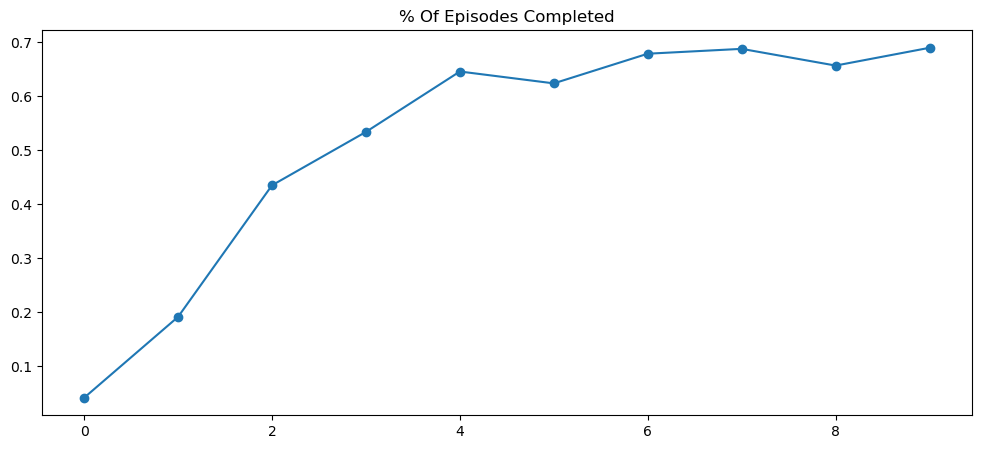

In [173]:
plt.figure(figsize = (12,5))
plt.title('% Of Episodes Completed')
plt.plot(np.arange(len(avg_reward_per_splits)), avg_reward_per_splits, 'o-')
plt.show()

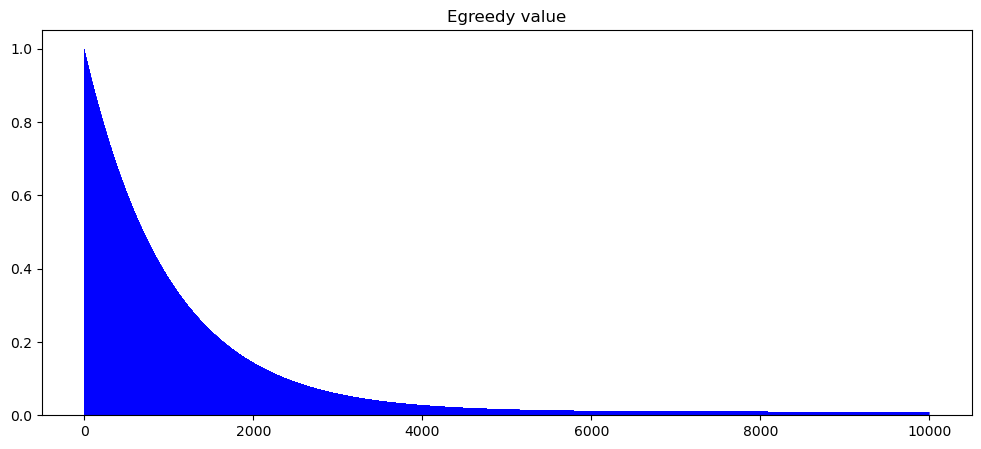

In [174]:
plt.figure(figsize=(12,5))
plt.title("Egreedy value")
plt.bar(np.arange(len(egreedy_values)), egreedy_values, alpha=0.6, color='blue', width=5)
plt.show()